In [1]:
import numpy as np
import keras.datasets.mnist as mnist
import matplotlib.pyplot as plt

# DATA IMPORT

In [2]:
data = mnist.load_data()

In [3]:
(x_train, y_train), (x_test, y_test) = data

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

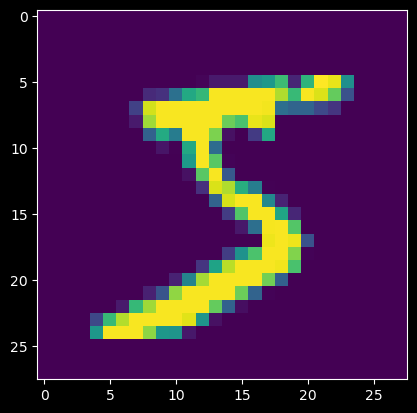

In [5]:
plt.imshow(x_train[0])

In [6]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

x_train = np.array(x_train/255., dtype=np.float32)
x_test = np.array(x_test/255., dtype=np.float32)

(60000, 784) (10000, 784)


In [7]:
# UTITLIY FUNCTION
def one_hot(Y):
    num_labels = len(set(Y))
    new_Y = []
    for label in Y:
        encoding = np.zeros(num_labels)
        encoding[label] = 1.
        new_Y.append(encoding)
    return np.array(new_Y)

In [8]:
y_train = one_hot(y_train)
y_test = one_hot(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

# LAYER CLASS

In [9]:
# CLASS FOR THE OPTIMIZERS, INHERITED FROM A COMMON PARENT OPTIMIZER CLASS
class Optimizer:
    def __init__(self, learning_rate=None, name=None):
        self.learning_rate = learning_rate
        self.name = name

    def config(self, layers):
        pass

    def optimize(self, idx, layers, grads, epoch_num, steps):
        pass 


class SGDM(Optimizer):
    def __init__(self, learning_rate=1e-2, initial_momentum=0.5, max_momentum=0.99):
        super().__init__()
        self.initial_momentum = initial_momentum
        self.max_momentum = max_momentum
        self.momentum = dict()
        self.learning_rate = learning_rate

    def config(self, layers):
        for i, _ in enumerate(layers):
            self.momentum[f'W{i}'] = 0
            self.momentum[f'b{i}'] = 0

    def optimize(self, layer_idx, layers, gradients, epoch_num, steps):
        momentum = min(self.initial_momentum * 1.2 ** (epoch_num - 1), self.max_momentum)

        self.momentum[f'W{layer_idx}'] = self.momentum[f'W{layer_idx}'] * momentum - self.learning_rate * gradients[f'dW{layer_idx}']
        self.momentum[f'b{layer_idx}'] = self.momentum[f'b{layer_idx}'] * momentum - self.learning_rate * gradients[f'db{layer_idx}']

        layers[layer_idx].W += self.momentum[f'W{layer_idx}']
        layers[layer_idx].b += self.momentum[f'b{layer_idx}']



class Nesterov(SGDM):
    def init(self, learning_rate):
        self.learning_rate = learning_rate
        super().init()

    def initialize_previous_momentum(self, idx):
        previous_momentum_W =  np.array(self.momentum[f'W{idx}'], copy=True)
        previous_momentum_b = np.array(self.momentum[f'b{idx}'], copy=True)
        return previous_momentum_W, previous_momentum_b

    def optimize(self, idx, layers, grads, epoch_num, steps):
        momentum_factor = min(self.initial_momentum * 1.2 ** (epoch_num - 1), self.max_momentum)

        previous_momentum_W, previous_momentum_b =  self.initialize_previous_momentum(idx)

        self.momentum[f'W{idx}'] = self.momentum[f'W{idx}'] * momentum_factor - self.learning_rate * grads[f'dW{idx}']
        self.momentum[f'b{idx}'] = self.momentum[f'b{idx}'] * momentum_factor - self.learning_rate * grads[f'db{idx}']

        layers[idx].W += -momentum_factor * previous_momentum_W + (1 + momentum_factor) * self.momentum[f'W{idx}']
        layers[idx].b += -momentum_factor * previous_momentum_b + (1 + momentum_factor) * self.momentum[f'b{idx}']


class Adagrad(Optimizer):
    def __init__(self, epsilon=1e-8, learning_rate=0.01):
        super().__init__()
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.v = {}

    def config(self, layers):
        for i in range(len(layers)):
            self.v[f'W{i}'] = 0
            self.v[f'b{i}'] = 0

    def optimize(self, layer_idx, layers, grads, epoch_num, steps):
        v_w = self.v[f'W{layer_idx}']
        v_b = self.v[f'b{layer_idx}']
        dW = grads[f'dW{layer_idx}']
        db = grads[f'db{layer_idx}']

        v_w += dW ** 2
        v_b += db ** 2

        w_update = - self.learning_rate * dW / (np.sqrt(v_w) + self.epsilon)
        b_update = - self.learning_rate * db / (np.sqrt(v_b) + self.epsilon)

        layers[layer_idx].W += w_update
        layers[layer_idx].b += b_update

        self.v[f'W{layer_idx}'] = v_w
        self.v[f'b{layer_idx}'] = v_b



class RMSprop(Optimizer):
    def __init__(self, decay_rate=0.9, epsilon=1e-8):
        super().__init__()
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.cache = {}

    def config(self, layers):
        for i in layers.keys():
            self.cache[f'W{i}'] = np.zeros_like(layers[i].W)
            self.cache[f'b{i}'] = np.zeros_like(layers[i].b)

    def optimize(self, idx, layers, grads, epoch_num, steps):
        dw = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        
        self.cache[f'W{idx}'] = self.decay_rate * self.cache[f'W{idx}'] + (1 - self.decay_rate) * dw ** 2
        self.cache[f'b{idx}'] = self.decay_rate * self.cache[f'b{idx}'] + (1 - self.decay_rate) * db ** 2
        
        w_update = - self.learning_rate * dw / (np.sqrt(self.cache[f'W{idx}'] + self.epsilon))
        b_update = - self.learning_rate * db / (np.sqrt(self.cache[f'b{idx}'] + self.epsilon))

        layers[idx].W += w_update
        layers[idx].b += b_update


class Adam(Optimizer):

    def __init__(self, learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                 weight_decay=False, gamma_init=1e-5, decay_rate=0.8):
        super().__init__()
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2 
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        if self.weight_decay:
            self.gamma_init = gamma_init
            self.decay_rate = decay_rate
        self.m = dict()  
        self.v = dict() 

    def config(self, layers):
        for i in layers.keys():
            self.m[f'W{i}'] = 0
            self.m[f'b{i}'] = 0
            self.v[f'W{i}'] = 0
            self.v[f'b{i}'] = 0

    def optimize(self, idx, layers, grads, epoch_num, steps): 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        beta1 = self.beta1

        self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 
        
        self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / (np.sqrt(vt_w) + self.epsilon)
        b_update = - self.learning_rate * mt_b / (np.sqrt(vt_b) + self.epsilon)
        
        if self.weight_decay:
            gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
            w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
            b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update

In [10]:
class Layer:
    def __init__(self, hidden_units, activation):
        self.hidden_units = hidden_units
        self.activation = activation
        self.W = None
        self.b = None
        
    def initialize_params(self, n_in, hidden_units):
        self.W = np.random.randn(n_in, hidden_units) * np.sqrt(2/n_in) 
        self.b = np.zeros((1, hidden_units))
    
    def forward(self, X):
        self.input = np.array(X, copy=True)

        if self.W is None:
            self.initialize_params(self.input.shape[1], self.hidden_units)

        self.Z = np.dot(X, self.W) + self.b
        self.A = self.activation_fn(self.Z)
        return self.A

    def activation_fn(self, z, derivative=False):
        if self.activation == 'relu':
            if derivative:
                return self.drelu(z)
            return self.relu(z)
        if self.activation == 'sigmoid':
            if derivative:
                return self.dsigmoid(z)
            return self.sigmoid(z)
        if self.activation == 'softmax':
            return self.softmax(z)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def dsigmoid(self, z):
        return Layer.sigmoid(z) * (1-Layer.sigmoid(z))

    def relu(self, z):
        return np.maximum(0, z)
    
    def drelu(self, z):
        return np.where(z<=0, 0, 1)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

# NEURAL NETWORK MODEL

In [11]:
class Model:
    def __init__(self, layers, epochs, learning_rate, optimizer=None, activation='relu', batch_size=32):

        self.layer = [784] + layers + [10]
        self.layers = dict()
        
        for i in range(0, len(self.layer)):
            self.layers[i] = Layer(self.layer[i], activation=activation)
        self.layers[len(self.layer)] = Layer(self.layer[-1], activation='softmax')

        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate

        # SETTING OPTIMIZER WITH PARAMETERS
        self.optimizer.config(self.layers)
        self.optimizer.epochs = self.epochs
        self.optimizer.learning_rate = self.learning_rate

        self.cache = {}
        self.grads = {}
        self.batch_size=batch_size

    def forward(self, x):
        for i in self.layers.keys():
            x = self.layers[i].forward(x)
            self.cache[f'W{i}'] = self.layers[i].W
            self.cache[f'Z{i}'] = self.layers[i].Z
            self.cache[f'A{i}'] = self.layers[i].A
        return x

    def backward(self, y):

        last_layer_idx = max(self.layers.keys())
        m = y.shape[0]

        self.grads[f'dZ{last_layer_idx}'] = self.cache[f'A{last_layer_idx}'] - y
        self.grads[f'dW{last_layer_idx}'] = 1 / m * self.layers[last_layer_idx].input.T @ self.grads[f'dZ{last_layer_idx}']
        self.grads[f'db{last_layer_idx}'] = 1 / m * np.sum(self.grads[f'dZ{last_layer_idx}'], axis=0, keepdims=True)

        for idx in reversed(range(0, last_layer_idx)):

            self.grads[f'dZ{idx}'] = self.grads[f'dZ{idx+1}'] @ self.cache[f'W{idx+1}'].T * self.layers[idx].activation_fn(self.cache[f'Z{idx}'], derivative=True) 
            self.grads[f'dW{idx}'] = 1 / m * self.layers[idx].input.T @ self.grads[f'dZ{idx}']
            self.grads[f'db{idx}'] = 1 / m * np.sum(self.grads[f'dZ{idx}'], axis=0, keepdims=True)
            
            assert self.grads[f'dW{idx}'].shape == self.cache[f'W{idx}'].shape

    def update_params(self, epoch_num, steps):
        for l_no in self.layers.keys():
            if self.optimizer is None:
                self.layers[l_no].W -= self.learning_rate * self.grads[f'dW{l_no}']
                self.layers[l_no].b -= self.learning_rate * self.grads[f'db{l_no}']
            else:
                self.optimizer.optimize(l_no, self.layers, self.grads, epoch_num, steps)

        
    def fit(self, x_train, y_train, x_test=None, y_test=None):

        losses = []
        train_accs = []
        val_accs = []
        val_losses = []

        for i in range(1, self.epochs+1):
            
            batches = self.create_batches(x_train, y_train, self.batch_size)
            epoch_loss = []
            steps = 0
            
            for x, y in batches:
                steps += 1
                preds = self.forward(x)
                loss = self.compute_loss(y, preds)
                epoch_loss.append(loss)

                # Backward propagation - calculation of gradients 
                self.backward(y)
                
                # update weights and biases of each layer
                self.update_params(i, steps)
                
            loss = sum(epoch_loss) / len(epoch_loss)
            losses.append(loss)

            val_pred = self.forward(x_test)
            val_loss = self.compute_loss(y_test, val_pred)
            val_losses.append(val_loss)

            # Predict with network on x_train
            train_preds = self.forward(x_train)
            c = np.argmax(train_preds, axis=1) == np.argmax(y_train, axis=1)
            train_acc = list(c).count(True) / len(c) * 100
            train_accs.append(train_acc)
            
            # Predict with network on x_test
            test_preds = self.forward(x_test)
            c = np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)
            val_acc = list(c).count(True)/len(c) * 100
            val_accs.append(val_acc)

            print(f'Epoch: {i} Loss: {loss} Train Acc: {train_acc} Val Loss: {val_loss} Val Acc: {val_acc}')            
                
        self.history = {'train_loss': losses, 'train_acc': train_accs, 'val_acc': val_accs, 'val_loss': val_losses}

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        L = -1./m * np.sum(Y * np.log(Y_hat))
        return L
    
    def create_batches(self, x, y, batch_size):
        m = x.shape[0]
        num_batches = m / batch_size
        batches = []
        for i in range(int(num_batches+1)):
            batch_x = x[i*batch_size:(i+1)*batch_size]
            batch_y = y[i*batch_size:(i+1)*batch_size]
            batches.append((batch_x, batch_y))

        if m % batch_size == 0:
            batches.pop(-1)

        return batches
    
    def __repr__(self):
        return str(self.layers)

In [12]:
# Hyperparameters
epochs = 20
lr = 1e-3
batch_size = 128
models = []

In [13]:
def run_model(layers, epochs, learning_rate, optimizer=None, activation='relu', batch_size=32):
    model = Model(layers=layers, epochs=epochs, learning_rate=learning_rate, optimizer=optimizer, activation=activation, batch_size=batch_size)
    model.fit(x_train, y_train, x_test, y_test)
    models.append(model)
    return model.history

In [14]:
# OPTIMIZERS

# SGD With Momentum
sgdm = SGDM(lr)

# Nestrov
nesterov = Nesterov(lr)

# adagrad
adagrad = Adagrad(lr)

# RMSProp
rmsprop = RMSprop(lr)

# Adam
adam = Adam(lr)

In [15]:
opts = [sgdm, nesterov, adagrad, rmsprop, adam]
name = ['sgdm', 'nesterov', 'adagrad', 'rmsprop', 'adam']

In [16]:
# Run all optimizers
opts_history = dict()
for i in range(len(opts)):
    print(f'Running {name[i]}')
    opts_history[name[i]] = run_model([256, 64], epochs, lr, opts[i], batch_size=batch_size)
    print()

Running sgdm
Epoch: 1 Loss: 2.0875899816181995 Train Acc: 35.77666666666667 Val Loss: 1.843187130468643 Val Acc: 35.76
Epoch: 2 Loss: 1.6384757826760623 Train Acc: 49.01333333333333 Val Loss: 1.4555073416374393 Val Acc: 48.61
Epoch: 3 Loss: 1.2999353027438607 Train Acc: 66.39166666666667 Val Loss: 1.1471011930893815 Val Acc: 66.19
Epoch: 4 Loss: 0.8355439659717014 Train Acc: 84.54333333333334 Val Loss: 0.5448833612144394 Val Acc: 85.36
Epoch: 5 Loss: 0.32216465892776663 Train Acc: 95.43333333333334 Val Loss: 0.17073280099137622 Val Acc: 95.0
Epoch: 6 Loss: 0.1493482090969632 Train Acc: 96.53 Val Loss: 0.14098365215414985 Val Acc: 95.76
Epoch: 7 Loss: 0.10480052775652604 Train Acc: 97.76166666666667 Val Loss: 0.10846032606945626 Val Acc: 96.76
Epoch: 8 Loss: 0.07782049499768036 Train Acc: 98.44666666666667 Val Loss: 0.09000740028998083 Val Acc: 97.3
Epoch: 9 Loss: 0.060001410731719246 Train Acc: 97.84666666666666 Val Loss: 0.11141454431906805 Val Acc: 96.63000000000001
Epoch: 10 Loss: 0

# PLOTS OF ACCURACY AND LOSS

In [17]:
def plotting_error(val_err, train_error, title):
    plt.plot(val_err, label='Validation Error')
    plt.plot(train_error, label='Training Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.show()

def plotting_accuracy(val_acc, train_acc, title):
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(train_acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

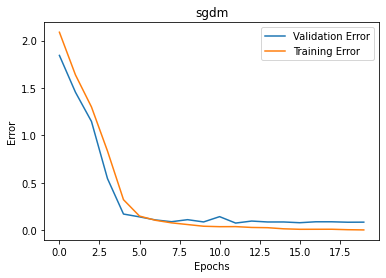

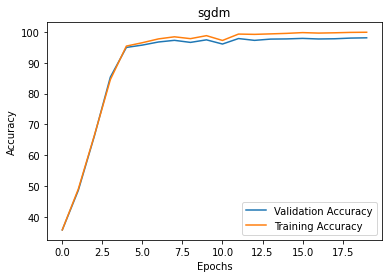

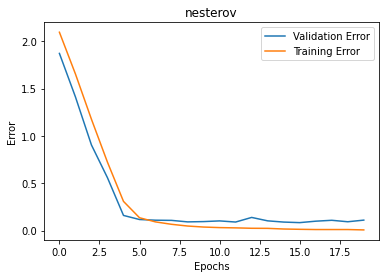

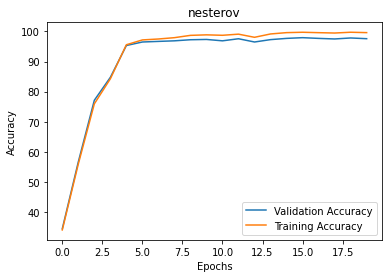

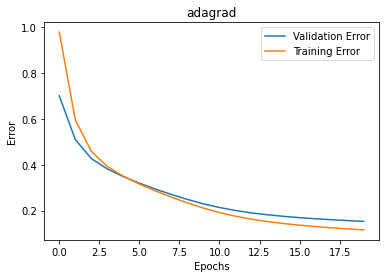

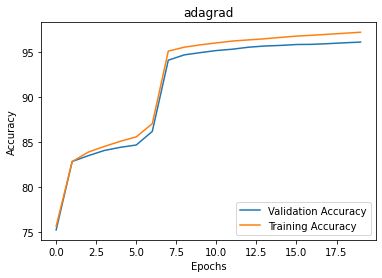

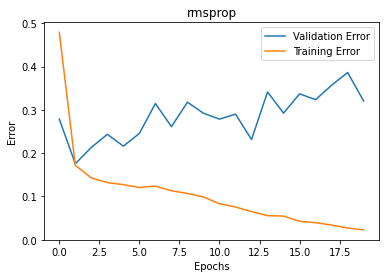

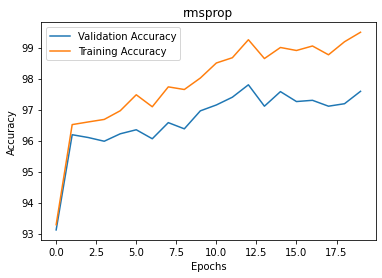

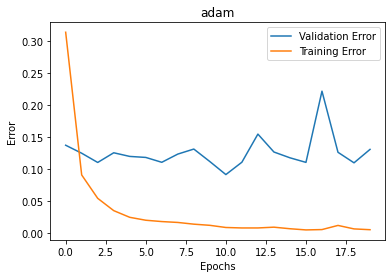

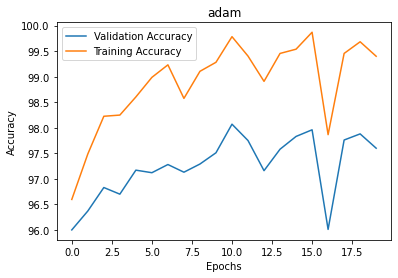

In [18]:
for i in opts_history.keys():
    plotting_error(opts_history[i]['val_loss'], opts_history[i]['train_loss'], i)
    plotting_accuracy(opts_history[i]['val_acc'], opts_history[i]['train_acc'], i)

From Above plots we can see that the models like **"ADAM"**, **"RMSProp"** are showing the case of overfitting, as the model is too complex for the data. The overfitting can be removed either by reducing the complexity of the model or by increasing the data. 

The models like **"ADAGRAD"**, **"SGD with MOMENTUM"** and **"NESTROV"** is showing great accuracy and loss reduction. This shows that with given hyperparameters and number layers and neurons in each layer, the model is not overfitting and is performing well.

In [19]:
import pickle
for i in range(len(name)):
  pickle.dump(models[i], open(f'{name[i]}.pkl', 'wb'))

In [25]:
import pickle, os
name = os.listdir('models_q1')
models = []
for i in name:
  models.append(pickle.load(open(f'models_q1/{i}', 'rb')))

In [26]:
test_preds = models[4].forward(x_test)
c = np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)
val_acc = list(c).count(True)/len(c) * 100
print(val_acc)

98.11999999999999
